In [3]:
import xgboost as xgb

from utils_data import *
from utils_evaluation import evaluate_numpy
from utils_plot import plot_confusion_matrix, plot_roc

In [9]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask_ml.preprocessing import StandardScaler

# Initialize a Dask cluster
client = Client()

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50602 instead
  warnings.warn(


In [6]:
data = PopulationData().load_raw('data/raw/train.csv')
data.encode_normalized_age()
data.encode_normalized_constitution()
data.encode_normalized_behavior()
data.encode_standardized_age()
data.encode_standardized_constitution()
data.encode_standardized_behavior()
data.encode_connection_lists()
data.encode_graph_nx()
data.encode_degree()
data.encode_degree_centrality()
data.encode_clustering_coefficient()
data.encode_normalized_degree()
data.encode_normalized_degree_centrality()
data.encode_normalized_clustering_coefficient()
data.encode_standardized_degree()
data.encode_standardized_degree_centrality()
data.encode_standardized_clustering_coefficient()
data.encode_connected_index_patient()
data.encode_distance_to_index_patient()
data.encode_normalized_distance_to_index_patient()
data.encode_standardized_distance_to_index_patient()
data.encode_sum_neighbor_age()
data.encode_sum_neighbor_constitution()
data.encode_sum_neighbor_behavior()
data.encode_sum_neighbor_degree()
data.encode_sum_neighbor_degree_centrality()
data.encode_sum_neighbor_clustering_coefficient()
data.encode_normalized_sum_neighbor_age()
data.encode_normalized_sum_neighbor_constitution()
data.encode_normalized_sum_neighbor_behavior()
data.encode_normalized_sum_neighbor_degree()
data.encode_normalized_sum_neighbor_degree_centrality()
data.encode_normalized_sum_neighbor_clustering_coefficient()
data.encode_standardized_sum_neighbor_age()
data.encode_standardized_sum_neighbor_constitution()
data.encode_standardized_sum_neighbor_behavior()
data.encode_standardized_sum_neighbor_degree()
data.encode_standardized_sum_neighbor_degree_centrality()
data.encode_standardized_sum_neighbor_clustering_coefficient()
data.encode_mean_neighbor_age()
data.encode_mean_neighbor_constitution()
data.encode_mean_neighbor_behavior()
data.encode_mean_neighbor_degree()
data.encode_mean_neighbor_degree_centrality()
data.encode_mean_neighbor_clustering_coefficient()
data.encode_normalized_mean_neighbor_age()
data.encode_normalized_mean_neighbor_constitution()
data.encode_normalized_mean_neighbor_behavior()
data.encode_normalized_mean_neighbor_degree()
data.encode_normalized_mean_neighbor_degree_centrality()
data.encode_normalized_mean_neighbor_clustering_coefficient()
data.encode_standardized_mean_neighbor_age()
data.encode_standardized_mean_neighbor_constitution()
data.encode_standardized_mean_neighbor_behavior()
data.encode_standardized_mean_neighbor_degree()
data.encode_standardized_mean_neighbor_degree_centrality()
data.encode_standardized_mean_neighbor_clustering_coefficient()
data.encode_test_train()

In [7]:
features = ['Normalized_Age',
			'Normalized_Behaviour',
			'Normalized_Constitution',
			'Normalized_Degree',
			'Normalized_Distance_to_Index_Patient',
			'Normalized_Sum_Neighbor_Age',
			'Normalized_Sum_Neighbor_Behaviour',
			'Normalized_Sum_Neighbor_Constitution',
			'Normalized_Sum_Neighbor_Degree']
train_features, train_labels = data.get_data_numpy(features=features, train='Train')
test_features, test_labels = data.get_data_numpy(features=features, train='Test')

In [10]:
train_features = da.from_array(train_features, chunks=1000)
test_features = da.from_array(test_features, chunks=1000)
train_labels = da.from_array(train_labels, chunks=1000)
test_labels = da.from_array(test_labels, chunks=1000)

In [28]:
# Create Dask DMatrix
dtrain = xgb.dask.DaskDMatrix(client, train_features, train_labels)
dtest = xgb.dask.DaskDMatrix(client, test_features, test_labels)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'error',
	'colsample_bytree': 0.6,
    'n_estimators': 200
}

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [29]:
# Train XGBoost model
model = xgb.XGBClassifier(**params, use_label_encoder=False)
model.fit(train_features, train_labels, eval_set=[(test_features, test_labels)], verbose=True)

XGBoostError: Invalid Parameter format for colsample_bytree expect float but value='[0.3, 0.6, 0.9]'

In [23]:
# Make predictions
test_predicted = model.predict(test_features)
test_probabilities = model.predict_proba(test_features)[:, 1]

In [24]:
test_predicted = model.predict(test_features)
test_probabilities = model.predict_proba(test_features)
test_probabilities = test_probabilities[:, 1]
accuracy, precision, recall, f1, auc_roc, confusion_matrix = evaluate_numpy(test_predicted, test_probabilities, test_labels)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Accuracy: 0.5864
Precision: 0.5741
Recall: 0.4424
F1: 0.4997
AUC-ROC: 0.6116


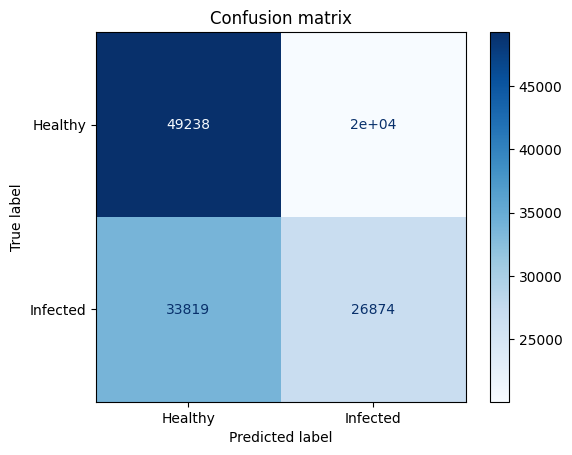

In [15]:
plot_confusion_matrix(confusion_matrix, ['Healthy', 'Infected'])

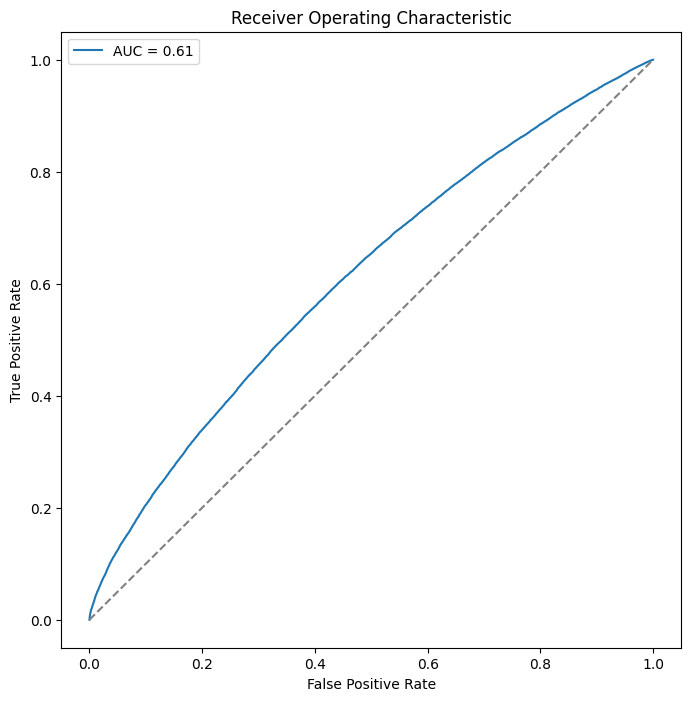

In [16]:
plot_roc(test_probabilities, test_labels)